In [1]:
import pandas as pd
import numpy as np

In [2]:
# reading the data
data = pd.read_csv('scrapper/comments_data_complete.csv')
data.head()

,date,comment
0,3/25/2002 5:54,I personally think that with a few tweaks the ...
1,3/25/2002 7:06,I am debating a new purchase and these two are...
2,3/25/2002 17:02,"Great handling, RWD, excellent engine and the ..."
3,3/25/2002 23:04,And no manual tranny. That may not matter to y...
4,3/26/2002 0:44,One beauty of BMW 3 Series is that there are s...


In [3]:
data.shape

(21733, 2)

## Task A - Ziff's law

In [26]:
data = data.dropna().reset_index(drop=True)
data.isnull().sum()
data.shape

(21682, 2)

In [27]:
# creating the text from comments 
text = ' '.join(data['comment'].tail(5000))
text = text.lower()
text

'\'02 rx300. gonna sit back, smell the oil and chill. researching a second opinion. wife wants at least another 4 years/40k miles out of it for kids to use and big grocery runs to bjs... my guess is it ain\'t gonna make it that far without some kind of tlc. doubt the oil issue will heal thyself! @markcincinnati - like i mentioned i got the 13 s4, mine has the sports diff and audi select- the sd is not noticeable 90% or more of the time under normal conditions - in reading other post enthusiast love it- me i\'m not totally sold that its a must have but for the extra 1k on a 55-60k car i could see wanting it- the prestige package for me is just a bunch of small extras that do nothing for performance and are just for added lux. i\'ve only had my car for 2 weeks- will say with snow tires its a bull. hills and turns not an issue even in 6 inches of loose snow. the car with snows is noisier then the old g was - but it does get 4-5 mpg better in my limited time in mixed driving. i drive mostl

In [28]:
# tokenizing words from latest 5000 comments for ziffs law
from nltk import word_tokenize, Counter
text_token = word_tokenize(text)
text_token_counter = Counter(text_token)
text_token_counter

Counter({"'02": 7,
         'rx300': 3,
         '.': 21189,
         'gon': 31,
         'na': 52,
         'sit': 43,
         'back': 530,
         ',': 22281,
         'smell': 6,
         'the': 24385,
         'oil': 200,
         'and': 9952,
         'chill': 3,
         'researching': 4,
         'a': 11626,
         'second': 130,
         'opinion': 69,
         'wife': 327,
         'wants': 66,
         'at': 2539,
         'least': 407,
         'another': 307,
         '4': 294,
         'years/40k': 1,
         'miles': 527,
         'out': 1104,
         'of': 7487,
         'it': 6815,
         'for': 4775,
         'kids': 35,
         'to': 10165,
         'use': 242,
         'big': 322,
         'grocery': 5,
         'runs': 21,
         'bjs': 1,
         '...': 688,
         'my': 3117,
         'guess': 204,
         'is': 6524,
         'ai': 26,
         "n't": 2988,
         'make': 533,
         'that': 6142,
         'far': 259,
         'without': 219,
 

In [29]:
# creating dataframe for frequency table
text_token_df = pd.DataFrame(data=None, columns=['words', 'frequency'])
text_token_df['words'] = text_token_counter.keys()
text_token_df['frequency'] = text_token_counter.values()
text_token_df

,words,frequency
0,'02,7
1,rx300,3
2,.,21189
3,gon,31
4,na,52
...,...,...
21691,"2,074",1
21692,speculation,1
21693,x1-size,1
21694,leaks,1


In [156]:
# sorting the text token df and getting ranks
text_token_df.sort_values('frequency', inplace=True, ascending=False)
text_token_df.reset_index(drop=True, inplace=True)
text_token_df['rank'] = text_token_df['frequency'].rank(method='max', ascending=False).astype(int)
text_token_df

,words,frequency,rank
0,the,24385,1
1,",",22281,2
2,.,21189,3
3,a,11626,4
4,i,11120,5
...,...,...,...
21691,mcconaughey,1,21696
21692,strolling,1,21696
21693,boulevard,1,21696
21694,withh,1,21696


In [157]:
# tranforming frequenct and rank to x & y variables
last_rank = text_token_df['rank'].max()
# n = text_token_df['frequency'].sum()
n = text_token_df.shape[0]
print(last_rank, n)

y = np.log(text_token_df['rank'])
x = np.log(text_token_df['frequency']/n/1)
df = pd.DataFrame(data={'x': x, 'y':y})

21696 21696


In [158]:
# hypothesis testing using linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
lr_model = LinearRegression(fit_intercept=False)
lr_model.fit(df[['x']], df['y'])
lr_model.coef_, r2_score(df['y'], lr_model.predict(df[['x']]))


(array([-1.01267883]), 0.9299456938902421)

In [159]:
# hypothesis testing using linear regression
import statsmodels.api as sm
model = sm.OLS(y, x)
results = model.fit()
results.conf_int()

,0,1
frequency,-1.0131,-1.012257


Text(0.5, 1.0, 'Ziff"s law')

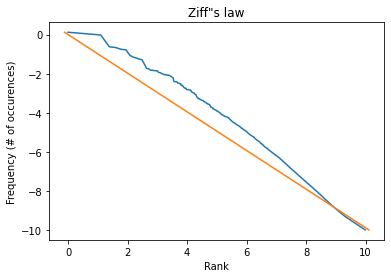

In [160]:
# plotting as per ziffs law
from matplotlib import pyplot as plt
plt.plot(y, x)
plt.plot(lr_model.predict(df[['x']]), x)
plt.xlabel('Rank')
plt.ylabel('Frequency (# of occurences)')
plt.title('Ziff"s law')

## Task B - Find top 10 Brands

In [161]:
text_token_df

,words,frequency,rank
0,the,24385,1
1,",",22281,2
2,.,21189,3
3,a,11626,4
4,i,11120,5
...,...,...,...
21691,mcconaughey,1,21696
21692,strolling,1,21696
21693,boulevard,1,21696
21694,withh,1,21696


### Cleaning brand file

In [36]:
# reading brand file
brand = pd.read_csv('car models and brands.csv')
print(brand.head())
print(brand['Brand'].unique())

# removing non brand words
non_brand_words = ['car', 'problem', 'seat', 'sedan']
mask1 = ~brand['Brand'].isin(non_brand_words)
brand = brand[mask1]

# correcting duplicates - hyundai
mask2 = brand['Brand'].isin(['hyndai kia', 'hyundai', 'hyundai,', 'hyundai.'])
brand.loc[mask2, 'Brand'] = 'hyundai'

# correcting duplicates - kia
mask3 = brand['Brand'].isin(['kia', 'kia,', 'kia.'])
brand.loc[mask3, 'Brand'] = 'kia'

# correcting duplicates - mercedes
mask4 = brand['Brand'].isin(['mercedes', 'mercedes benz', 'mercedes-benz'])
brand.loc[mask4, 'Brand'] = 'mercedes'

# correcting duplicates - nissan
mask5 = brand['Brand'].isin(['nissan', 'nissan.'])
brand.loc[mask5, 'Brand'] = 'nissan'

# correcting duplicates - toyota
mask6 = brand['Brand'].isin(['toyata', 'toyota'])
brand.loc[mask6, 'Brand'] = 'toyota'

# correcting duplicates - volkswagen
mask7 = brand['Brand'].isin(['volkswagen', 'volkwagen'])
brand.loc[mask7, 'Brand'] = 'volkswagen'

# dropping duplicates
brand.drop_duplicates(inplace=True)

# removing models with two brands
model_brand_count = brand['Model'].value_counts()
models_to_remove = model_brand_count[model_brand_count > 1].index
brand = brand[~brand['Model'].isin(models_to_remove)]

print(brand['Brand'].unique())

   Brand    Model
0  acura  integra
1  acura   legend
2  acura    vigor
3  acura      rlx
4  acura      ilx
['acura' 'audi' 'bmw' 'buick' 'cadillac' 'car' 'chevrolet' 'chrysler'
 'dodge' 'ford' 'honda' 'hyndai kia' 'hyundai' 'hyundai,' 'hyundai.'
 'infiniti' 'kia' 'kia,' 'kia.' 'lincoln' 'mazda' 'mercedes'
 'mercedes benz' 'mercedes-benz' 'mercury' 'mitsubishi' 'nissan' 'nissan.'
 'pontiac' 'problem' 'saturn' 'seat' 'sedan' 'subaru' 'suzuki' 'toyata'
 'toyota' 'volkswagen' 'volkwagen' 'volvo']
['acura' 'audi' 'bmw' 'buick' 'cadillac' 'chevrolet' 'chrysler' 'dodge'
 'ford' 'honda' 'hyundai' 'infiniti' 'kia' 'lincoln' 'mazda' 'mercedes'
 'mercury' 'mitsubishi' 'nissan' 'pontiac' 'saturn' 'subaru' 'suzuki'
 'toyota' 'volkswagen' 'volvo']


### Top 10 brands

         Brand  frequency
1         audi       2132
2          bmw       1965
0        acura       1018
9        honda        788
15    mercedes        573
24  volkswagen        474
4     cadillac        406
11    infiniti        370
10     hyundai        336
23      toyota        287


<BarContainer object of 10 artists>

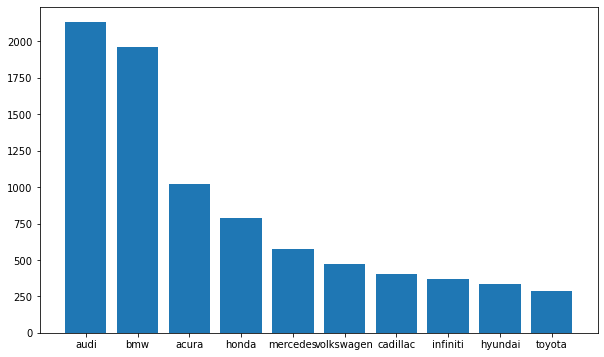

In [46]:
# getting stopword list from nltk
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')

# removing stop words from word lists
mask1 = ~text_token_df['words'].isin(stopwords_list)
token_cleaned_df = text_token_df[mask1]

# getting brand frequency
mask2 = token_cleaned_df['words'].isin(brand['Brand'])
brand_freq = token_cleaned_df[mask2]
brand_freq = brand_freq[['words', 'frequency']]
brand_freq.columns = ['Brand', 'frequency']

# getting brand frequency from model frequency
car_freq = token_cleaned_df.merge(brand, right_on='Model', left_on='words')
car_freq = car_freq.groupby('Brand')['frequency'].sum().reset_index()

# concating 
brand_freq_all = pd.concat([brand_freq, car_freq], axis=0)
brand_freq_all = brand_freq_all.groupby('Brand')['frequency'].sum().reset_index()
brand_freq_all.sort_values(ascending=False, inplace=True, by='frequency')

# top 10 brands
top10_brands = brand_freq_all.head(10)
print(top10_brands)

plt.figure(figsize=(10, 6))
plt.bar(top10_brands['Brand'], top10_brands['frequency'])

## Task C - Brand-Brand Lift

Steps to get brand-brand lift
1. create columns with brand names
2. look for 'brand' name in comment from data df

In [38]:
data.head()

,date,comment
0,3/25/2002 5:54,I personally think that with a few tweaks the ...
1,3/25/2002 7:06,I am debating a new purchase and these two are...
2,3/25/2002 17:02,"Great handling, RWD, excellent engine and the ..."
3,3/25/2002 23:04,And no manual tranny. That may not matter to y...
4,3/26/2002 0:44,One beauty of BMW 3 Series is that there are s...


In [42]:
# creating brand wise columns to get occurence into a dataframe
brand_occurence_df = pd.DataFrame(np.zeros((data.shape[0], 10)))
brand_occurence_df.columns = top10_brands['Brand'].values

# appending comment df with brand occurence df
brand_occurence_df = pd.concat([data, brand_occurence_df], axis=1)

# geting occurence columns populated
for c in brand_occurence_df.iloc[:, 2:]:
    print('calculating occurence in comment for brand - ', c)
    brand_occurence_df[c] = brand_occurence_df['comment'].str.contains(c).astype(int)

print(brand_occurence_df.head())

calculating occurence in comment for brand -  audi
calculating occurence in comment for brand -  bmw
calculating occurence in comment for brand -  acura
calculating occurence in comment for brand -  honda
calculating occurence in comment for brand -  mercedes
calculating occurence in comment for brand -  volkswagen
calculating occurence in comment for brand -  cadillac
calculating occurence in comment for brand -  infiniti
calculating occurence in comment for brand -  hyundai
calculating occurence in comment for brand -  toyota
              date                                            comment  audi  \
0   3/25/2002 5:54  I personally think that with a few tweaks the ...     0   
1   3/25/2002 7:06  I am debating a new purchase and these two are...     0   
2  3/25/2002 17:02  Great handling, RWD, excellent engine and the ...     0   
3  3/25/2002 23:04  And no manual tranny. That may not matter to y...     0   
4   3/26/2002 0:44  One beauty of BMW 3 Series is that there are s...  

audi          300
bmw           276
acura         191
honda          89
mercedes       45
volkswagen     11
cadillac       55
infiniti      127
hyundai        21
toyota         35
dtype: int64


<BarContainer object of 10 artists>

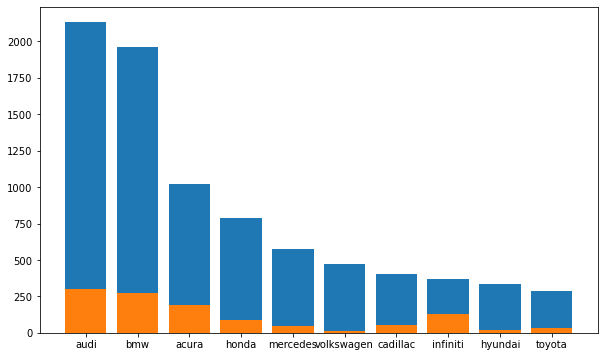

In [55]:
# CHECK
# testing the total occurence by brand in comments vs total frequency in complete text 
comment_mentions = brand_occurence_df.iloc[:, 2:].sum()
print(comment_mentions)

plt.figure(figsize=(10, 6))
plt.bar(top10_brands['Brand'], top10_brands['frequency'])
plt.bar(comment_mentions.index, comment_mentions)

In [48]:
# getting required packages for lift calc
!pip install mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [186]:
# generating lifts
brand_apriori = apriori(brand_occurence_df.iloc[:, 2:], min_support=0.000001, use_colnames=True)
rules = association_rules(brand_apriori, metric="lift", min_threshold=0)

# cleaning to get one brand to another brand lift
mask1 = rules['antecedents'].map(lambda row: len(row)) == 1
mask2 = rules['consequents'].map(lambda row: len(row)) == 1
rules_one_brand = rules[(mask1 & mask2)]

# converting columns data types
rules_one_brand['antecedents'] = rules_one_brand['antecedents'].map(lambda row: list(row)[0])
rules_one_brand['consequents'] = rules_one_brand['consequents'].map(lambda row: list(row)[0])

rules_one_brand

<ipython-input-186-a3e753b55a61>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules_one_brand['antecedents'] = rules_one_brand['antecedents'].map(lambda row: list(row)[0])
<ipython-input-186-a3e753b55a61>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules_one_brand['consequents'] = rules_one_brand['consequents'].map(lambda row: list(row)[0])


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,bmw,audi,0.012729,0.013836,0.001522,0.119565,8.641377,0.001346,1.120087
1,audi,bmw,0.013836,0.012729,0.001522,0.110000,8.641377,0.001346,1.109293
2,audi,acura,0.013836,0.008809,0.000692,0.050000,5.675916,0.000570,1.043359
3,acura,audi,0.008809,0.013836,0.000692,0.078534,5.675916,0.000570,1.070212
4,honda,audi,0.004105,0.013836,0.000277,0.067416,4.872360,0.000220,1.057453
...,...,...,...,...,...,...,...,...,...
65,hyundai,infiniti,0.000969,0.005857,0.000046,0.047619,8.129734,0.000040,1.043850
66,infiniti,toyota,0.005857,0.001614,0.000138,0.023622,14.633521,0.000129,1.022540
67,toyota,infiniti,0.001614,0.005857,0.000138,0.085714,14.633521,0.000129,1.087343
68,hyundai,toyota,0.000969,0.001614,0.000138,0.142857,88.497959,0.000137,1.164783


In [187]:
# CHECK
# ideally for top 10 brands - total row count should be 90 (100 - 10 same brand comp)
print(rules_one_brand.pivot_table(index='antecedents', columns='consequents', values='lift', aggfunc='count'))

# checking co-occurence of two words in comments
antecedents = 'toyota'
consequents = 'cadillac'
# print((antecedents in data['comment']) & (consequents in data['comment']))
assert len(rules[(rules['antecedents'] == antecedents) & (rules['consequents'] == consequents)]) == 0

consequents  acura  audi  bmw  cadillac  honda  hyundai  infiniti  mercedes  \
antecedents                                                                   
acura          NaN   1.0  1.0       NaN    1.0      1.0       1.0       1.0   
audi           1.0   NaN  1.0       1.0    1.0      1.0       1.0       1.0   
bmw            1.0   1.0  NaN       1.0    1.0      1.0       1.0       1.0   
cadillac       NaN   1.0  1.0       NaN    NaN      NaN       1.0       1.0   
honda          1.0   1.0  1.0       NaN    NaN      1.0       1.0       NaN   
hyundai        1.0   1.0  1.0       NaN    1.0      NaN       1.0       NaN   
infiniti       1.0   1.0  1.0       1.0    1.0      1.0       NaN       1.0   
mercedes       1.0   1.0  1.0       1.0    NaN      NaN       1.0       NaN   
toyota         1.0   1.0  1.0       NaN    1.0      1.0       1.0       1.0   
volkswagen     1.0   1.0  1.0       NaN    1.0      NaN       1.0       NaN   

consequents  toyota  volkswagen  
antecedents      

In [189]:
lift_pivot = rules_one_brand.pivot_table(index='antecedents', columns='consequents', values='lift', aggfunc='mean')
lift_pivot

consequents,acura,audi,bmw,cadillac,honda,hyundai,infiniti,mercedes,toyota,volkswagen
antecedents,,,,,,,,,,
acura,NaN,5.675916,7.814667,NaN,20.407789,5.405635,23.239972,5.045259,3.243381,41.279391
audi,5.675916,NaN,8.641377,2.628121,4.872360,3.441587,7.398058,8.030370,8.259810,13.140606
bmw,7.814667,8.641377,NaN,8.569960,6.178717,14.963423,11.134201,13.965862,11.222567,7.141634
cadillac,NaN,2.628121,8.569960,NaN,NaN,NaN,3.104080,17.520808,NaN,NaN
honda,20.407789,4.872360,6.178717,NaN,NaN,34.802568,1.918252,NaN,55.684109,44.294178
hyundai,5.405635,3.441587,14.963423,NaN,34.802568,NaN,8.129734,NaN,88.497959,NaN
infiniti,23.239972,7.398058,11.134201,3.104080,1.918252,8.129734,NaN,11.381627,14.633521,15.520401
mercedes,5.045259,8.030370,13.965862,17.520808,NaN,NaN,11.381627,NaN,13.766349,NaN
toyota,3.243381,8.259810,11.222567,NaN,55.684109,88.497959,14.633521,13.766349,NaN,NaN


### Question - why do I need to populate lift with correction when the objective is creating MDS, which is already a high dim problem and no co-occurence will just reduce certain degrees of freedom for the plotting

## Task D - MDS